### Photonic lantern empirical identification procedure

This was so hard. I've been thinking about it on and off for about a year now and I'm really glad it actually works!

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %pip install git+https://github.com/aditya-sengupta/photonics
import numpy as np
import matplotlib as mpl
# mpl.use('pgf')
from matplotlib import pyplot as plt
from hcipy import ModeBasis
from tqdm import trange

from photonics.simulations.command_matrix import make_command_matrix
from photonics.simulations.lantern_optics import LanternOptics
from photonics.simulations.optics import Optics
from photonics.utils import nanify, lmap, rms

/Users/adityasengupta/projects/seal/photonics/.venv/lib/python3.12/site-packages/juliacall/__init__.py:247: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


### Optics setup

We set up the optics of a 19-port photonic lantern, compute an interaction matrix, and take its SVD. The resulting matrix in the input space, $V^T$, gives us 18 phase screens that make a suitable basis that we'll need in a minute.

In [3]:
optics = Optics(lantern_fnumber=6.5, num_pupil_px=180)
lo = LanternOptics(optics)
N = lo.nports
lo.nmodes = 18
make_command_matrix(optics.deformable_mirror, lo, optics.wf)
_, _, vh = np.linalg.svd(lo.interaction_matrix)
coeff_array = np.zeros(len(optics.zernike_basis))

100%|██████████| 18/18 [00:08<00:00,  2.03it/s]


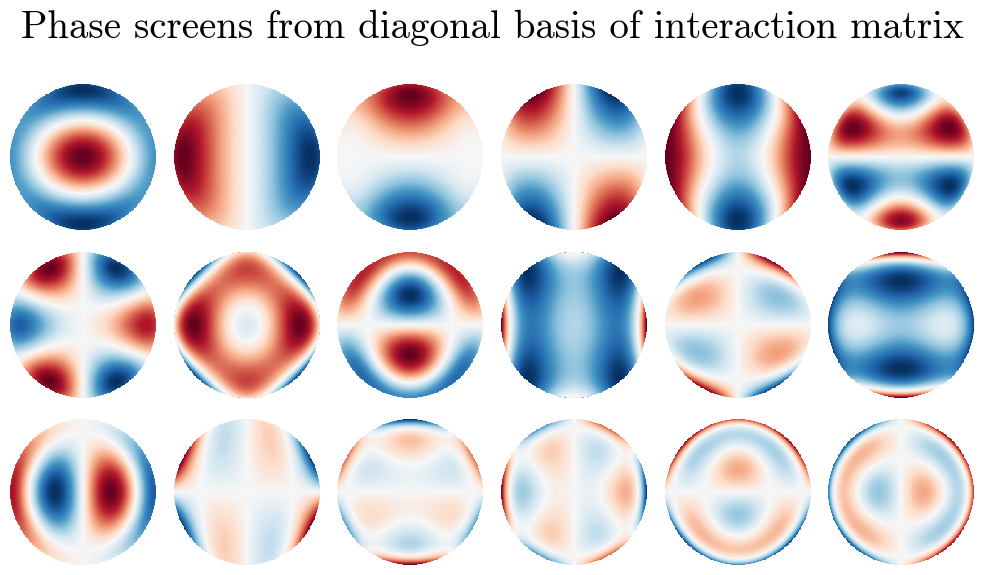

In [4]:
fig, axs = plt.subplots(3, 6, figsize=(10, 6))
for i, row in enumerate(vh):
    coeff_array[:len(row)] = row
    ax = axs[i // (len(vh)//3), i % (len(vh)//3)]
    mode = optics.zernike_basis.linear_combination(coeff_array)
    ax.imshow(nanify(mode - np.mean(mode), optics.aperture).shaped, cmap='RdBu', origin='lower')
    ax.set_axis_off()
plt.suptitle("Phase screens from diagonal basis of interaction matrix", fontsize=28)
plt.tight_layout()
plt.savefig("../../figures/diagonal_phase_screens.pdf")

In simulation, we describe the photonic lantern's input electric field as a linear combination of the "lantern basis". We find the lantern basis by illuminating each single-mode fiber in turn with the fundamental mode. We can't do this with a real lantern that isn't "pigtailed", such as the ones we've had in the lab, so with a real lantern we can't see what the actual lantern basis is. Further, we're not guaranteed that we can get to each element of the lantern basis, because we're restricted to electric fields we can produce with phases applied to the DM or SLM, and there's no reason to believe this should include any electric fields that result in illuminating just one port.

We work around this as follows. Pick some number $K \geq N$; this will be the number of basis elements we have in the "fitting basis", which we choose so that it's fully attainable. The higher $K$ is, the lower the fitting error we'll get, but the more queries we'll have to do to fully constrain the propagation matrix. We set the fitting basis as follows:

- the electric field of the unaberrated PSF
- the electric fields resulting from the N-1 SVD phase screens above
- K-N electric fields from randomly-chosen phase screens (there might be a better way to add in these "nuisance terms")

Below, I generate this basis, and plot the intensities from just the middle N-1 components. For simplicity in this notebook I'll choose $K = N$, but this could change if necessary.

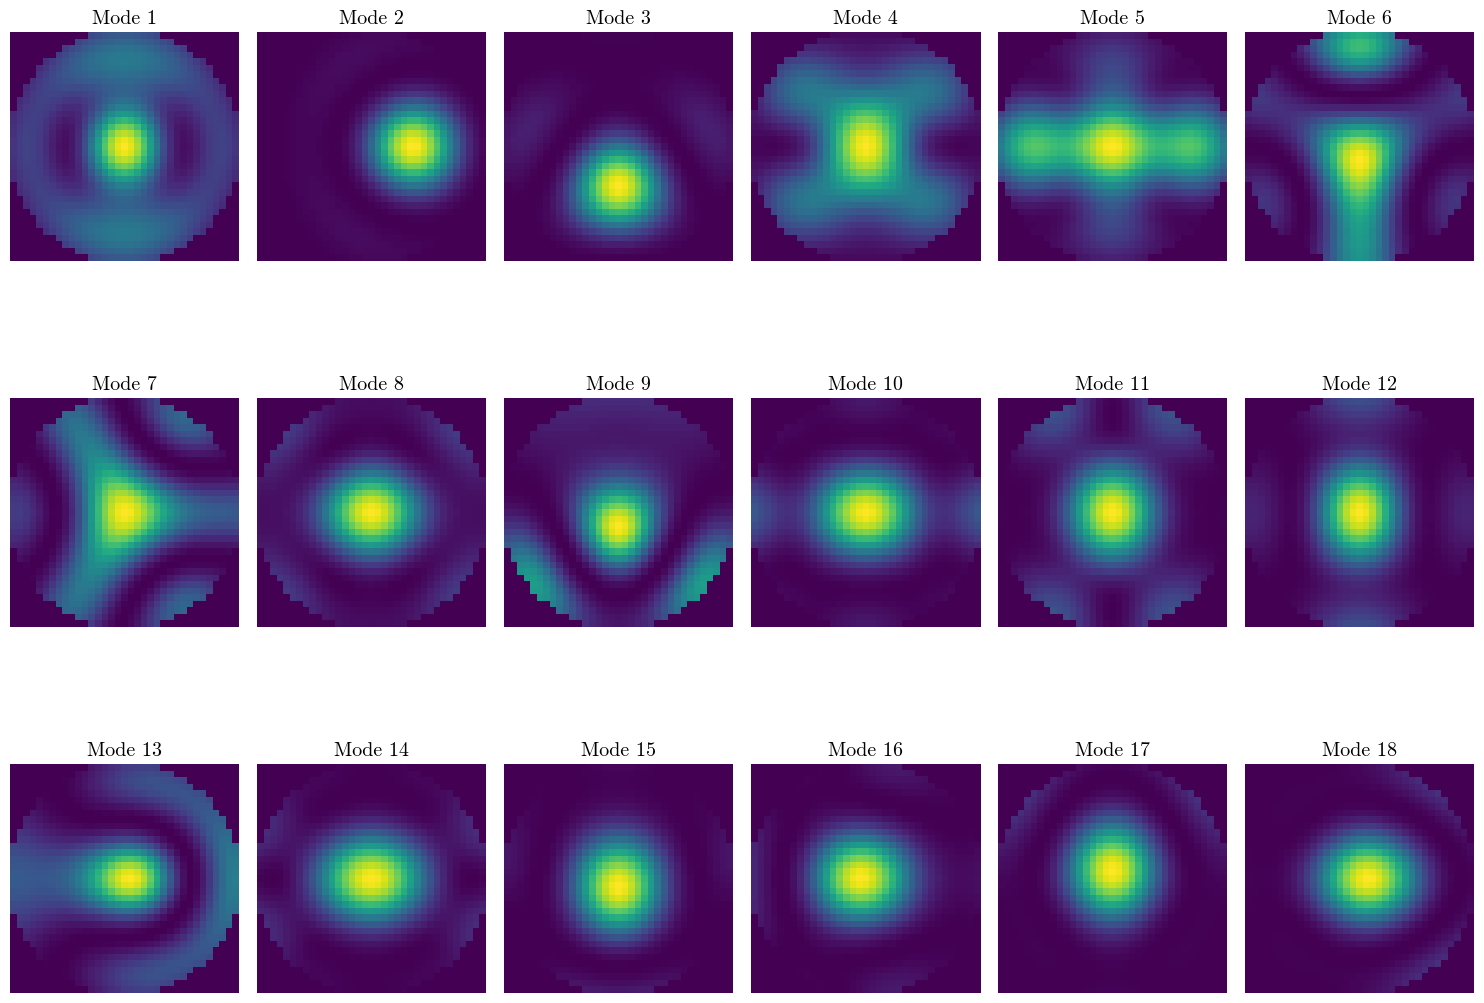

In [5]:
K = N
assert K >= N
input_pupils = [optics.wf] + [optics.zernike_to_pupil(np.arange(18), a) for a in vh] + [optics.zernike_to_pupil(np.arange(18), a) for a in np.random.normal(scale=0.1, size=(K-19))]
input_wavefronts = lmap(optics.focal_propagator, input_pupils)
input_basis_fields = [w.electric_field.shaped for w in input_wavefronts]
fitting_basis = ModeBasis([lo.sanitize_output(x) for x in input_basis_fields])
fig, axs = plt.subplots(3, 6, figsize=(15, 12))
for i, f in enumerate(input_basis_fields[1:19]):
    ax = axs[i // 6, i % 6]
    f = lo.input_to_2d(lo.sanitize_output(f))
    ax.imshow(np.abs(f) ** 2, origin='lower')
    ax.set_title(f"Mode {i+1}")
    ax.set_axis_off()
plt.tight_layout()
plt.show()

The "propagation matrix" of the lantern is an $N \times K$ matrix that takes in a focal-plane electric field expressed in the fitting basis, and returns the electric fields on each of the output ports. If we knew the lantern basis, and chose that as our fitting basis with $K = N$, this would be the identity. Lin et al. 2022 uses a definition of the propagation matrix involving the LP modes on the input, but this isn't desirable for characterization because we have no guarantee that those are attainable with just phase shifts.

Below, I build the propagation matrix, which we'll try and recover. I can't directly confirm in reality that this has rank $N$ like I want (you could imagine a poorly-chosen fitting basis resulting in some redundant components in electric field, but this not getting identified empirically), but we can confirm that its norm-squared matrix has rank $N$, and these two statements are equivalent.

In [6]:
lantern_basis = ModeBasis(lo.outputs.T) # this is the lantern basis, in which A is the identity
# expanding in this basis is equivalent to getting readouts of the lantern
A = np.zeros((lo.nports, K), dtype=np.complex128)
for i in range(K):
    A[:,i] = lantern_basis.coefficients_for(lo.sanitize_output(input_basis_fields[i]))
    
np.linalg.matrix_rank(A) == np.linalg.matrix_rank(np.abs(A) ** 2) == N

np.True_

From here, I assert that since $A$ has rank $N$, it is ~equivalent to do either of the following:

1. Project a PSF onto the fitting basis and multiply by A.
2. Project a PSF onto the lantern basis.

We get some amount of fitting error because we don't know exactly how to pick a fitting basis whose span contains the lantern basis (or because of discretization issues; I'd like second opinions on this!)

Assuming this is the case, we've reduced the problem to identifying $A$ by feeding in known linear combinations of the fitting basis, which is a linear algebra problem I'll have us solve. Let's make our query set. For the sake of the linear algebra problem, it doesn't matter what phase coefficients we pick, as long as we know its electric field's expansion in the fitting basis. But for the sake of practicality, we want to tune this similarly to how we might tune the poke amplitude for an interaction matrix: sufficiently small that we don't run into significant crosstalk (the linear independence of the fitting basis is dependent on the discretization so it's slightly imperfect, or maybe this isn't the killer issue, I can't tell), but sufficiently large that we can distinguish the outputs.

In [7]:
# Transforming phase screens to the focal plane
# We'll later transform them to the PL as we need them
# which is a lot quicker because we'll show it's just one NxN matrix multiplication
max_amp = 0.2
queries = []
for i in trange(K*(K-1)):
    z = np.random.uniform(low=-max_amp, high=max_amp, size=N) # scale arbitrary, should be small
    focal_efield = optics.focal_propagator(optics.zernike_to_pupil(np.arange(N), z))
    queries.append(focal_efield)
# "queries" has the electric fields we'll put into the lantern

100%|██████████| 342/342 [01:25<00:00,  3.98it/s]


In [8]:
max_intensity = np.max([x.intensity for x in queries])
queries_efields = [q.electric_field / max_intensity for q in queries]
queries_in_lantern_footprint = [lo.sanitize_output(x.shaped) for x in queries_efields]
queries_in_lantern_basis = [lantern_basis.coefficients_for(x) for x in queries_in_lantern_footprint]
queries_in_fitting_basis = [fitting_basis.coefficients_for(x) for x in queries_in_lantern_footprint]

We can compute the fractional error due to using $A$ times the fitting-basis representation rather than the lantern-basis representation, and it's small but not zero. Interestingly if you increase the scale factor above, you find that the fitting basis ends up providing a more accurate representation than the lantern basis. The average error stays fairly low, but there usually end up being some significant outliers, and this ends up being driven not by the inadequacy of the fitting basis, but by the mismatch between the lantern-basis representation and what we put in. That is, there's components that are being faithfully represented from the input that don't make it to the end of the lantern. I would've expected these to be removed by $A$ but apparently that's not happening. Weird.

In [9]:
errors = []
for (lcoeffs, fcoeffs) in zip(queries_in_lantern_basis, queries_in_fitting_basis):
    error = rms(np.abs(((A @ fcoeffs) - lcoeffs) / (lcoeffs)))
    errors.append(error)
average_error = np.mean(errors)
lowest_error = np.min(errors)
highest_error = np.max(errors)
print(f"Lowest error: {lowest_error:.3f}")
print(f"Average error: {average_error:.3f}")
print(f"Highest error: {highest_error:.3f}")

Lowest error: 0.004
Average error: 0.023
Highest error: 0.060


/var/folders/tp/3ycddlmd04g4hd49l9367fgr0000gn/T/ipykernel_80426/168000393.py:10: RuntimeWarning: divide by zero encountered in log10
  return np.log10(np.abs(x) / np.max(np.abs(x)))


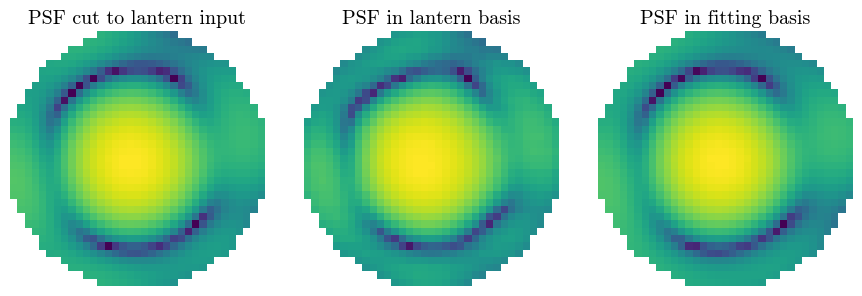

In [10]:
k = np.argmax(errors) # plot the worst case
lantern_basis_expression = lantern_basis.linear_combination(queries_in_lantern_basis[k])
zernike_basis_expression = fitting_basis.linear_combination(queries_in_fitting_basis[k])
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
query_cut_to_lantern = lo.input_to_2d(lo.sanitize_output(queries[k].electric_field.shaped))
for ax in axs:
    ax.set_axis_off()

def to_log_normalized(x):
    return np.log10(np.abs(x) / np.max(np.abs(x)))

axs[0].imshow(to_log_normalized(query_cut_to_lantern), vmin=-2)
axs[0].set_title("PSF cut to lantern input")
axs[1].imshow(to_log_normalized(lo.input_to_2d(lantern_basis_expression)), vmin=-2)
axs[1].set_title("PSF in lantern basis")
axs[2].imshow(to_log_normalized(lo.input_to_2d(zernike_basis_expression)), vmin=-2)
axs[2].set_title("PSF in fitting basis")
plt.tight_layout()
plt.show()

So this isn't perfect, but it's close enough. I'd imagine on a real bench we'll have sources of error that dominate above this.

We'll move into identifying $A$ now. It's easy to identify its intensity, since we know the fitting basis and can just put in every element to identify each column. For numerical simplicity, I'll say we can only query $A$ through the function `query`, and we'll also keep track of how many times it's been called (the number of PL propagations we have to do):

In [11]:
# https://stackoverflow.com/questions/44968004/how-to-count-function-calls-using-decorators
def call_counter(func):
    def helper(*args, **kwargs):
        helper.calls += 1
        return func(*args, **kwargs)
    helper.calls = 0
    return helper

In [12]:
@call_counter
def query(x):
    return np.abs(np.dot(A, x)) ** 2

In [13]:
query.calls

0

We identify the amplitude of A by injecting each basis element in:

In [14]:
absA = np.zeros((N,N))
base_query = np.zeros(K)
for i in range(K):
    # Corresponds to putting in each element of the fitting basis.
    # We interpret A as being a set of coefficients over the fitting basis
    # so later on when this is fully debugged, I can rewrite this as queries on the lantern itself
    base_query[:] = 0.0
    base_query[i] = 1.0
    absA[:,i] = np.sqrt(query(base_query))
    
assert np.allclose(np.abs(A), absA)

In [15]:
query.calls

19

Now we have to do phase identification. This is why we needed the queries above!

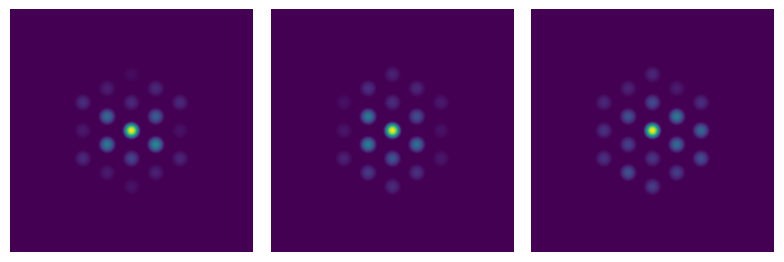

In [16]:
# just for fun, here's a few of the lantern outputs (sqrt stretch, i.e. I don't square before showing intensities)
query_subset = [query(queries_in_fitting_basis[i]) for i in np.random.randint(len(queries_in_fitting_basis), size=3)]
fig, axs = plt.subplots(1, 3, figsize=(8, 10))
for (ax, coeffs) in zip(axs, query_subset):
    ax.set_axis_off()
    img = sum([c * lf for (c, lf) in zip(coeffs, lo.plotting_launch_fields)])
    ax.imshow(np.abs(img))
plt.tight_layout()
plt.show()

For each of the queries, we know its representation in the fitting basis, and we know its query under $A$ looks like

$ \text{query response} = |Aq_i|^2_p = |\sum_{k=1}^K A_{pk} q_{ki}|^2 $

Here, $i$ indexes the query number. A query is a linear combination of the fitting basis, which is indexed by $k$. $A$ is a map from the fitting basis to the electric fields on each port, indexed by $p$.

We'll need a general expansion of a sum of complex numbers under $||^2$ to do this; this is given by

$ |a + b|^2 = |a|^2 + |b|^2 + 2 |a| |b| \cos(\phi_a - \phi_b) $.

This lets us expand this expression as follows:

$ |Aq_i|^2_p = |\sum_{k=1}^K A_{pk} q_{ki}|^2 = \sum_{k=1}^K |A_{pk}|^2 |q_{ki}|^2 + 2\sum_{l=1}^K \sum_{m = 1}^{l-1} |A_{pl}| |A_{pm}| |q_{li}| |q_{mi}| \cos(\Phi_{pl} - \Phi_{pm} + \phi_{li} - \phi_{mi}) $

where for convenience I've set $\Phi_{ab} = \arg A_{ab}$ and $\phi_{ab} = \arg q_{ab}$. We're now iterating over the fitting basis twice and computing cross terms; these iterations are indexed by $l$ and $m$.

This gives us a linear system in the terms with the form $\cos(\Phi_{pl} - \Phi_{pm} + \phi_l - \phi_m)$. The issue here is $q_l, q_m$ don't remain constant, so we're really getting information about a different angle every time! This is easily resolved, though:

$ \cos(\Phi_{pl} - \Phi_{pm} + \phi_{li} - \phi_{mi}) = \cos(\Phi_{pl} - \Phi_{pm}) \cos(\phi_{li} - \phi_{mi}) - \sin(\Phi_{pl} - \Phi_{pm}) \sin(\phi_{li} - \phi_{mi})$

and we know all the $\phi_i$-s, so this extends our linear system even further! We have $N(N-1)$ variables (halved for permutation, doubled for both sine and cosine). There's some degree of redundancy because we know that $\cos^2 x = 1 - \sin^2 x$, but we'll leave that out. So we end up needing $N(N-1)$ queries for the off-diagonal terms and $N$ for the diagonal terms, $N^2$ in total.

We have $K(K-1)$ examples overall, with $N$ ports each. What we've just generated is the $b$ matrices in $Cx = b$ for the $N$ problems we'll have to solve. So we need to make coefficient matrices as follows:

$ C_p \left[\begin{matrix} \cos(\Phi_{p1} - \Phi_{p2}) \\ \sin(\Phi_{p1} - \Phi_{p2}) \\ \cos(\Phi_{p1} - \Phi_{p3}) \\ \sin(\Phi_{p1} - \Phi_{p3}) \\ \cos(\Phi_{p2} - \Phi_{p3}) \\ \sin(\Phi_{p2} - \Phi_{p3}) \\ \vdots \end{matrix}\right] = b_p $ 

How do we populate $C_p$ to make this work? Let's say there's some mapping $(l, m) \iff n$ just so we don't clutter the index convention. Now $n$ is indexing cross terms in the fitting basis, but with just one number rather than two, so that we can build the linear system we need.

$ \begin{align} C_{p,2n,i} &= &|A_{pl}| |A_{pm}| |q_{li}| |q_{mi}| \cos(\phi_{li} - \phi_{mi}) \\
C_{p,2n+1,i} &= &-|A_{pl}| |A_{pm}| |q_{li}| |q_{mi}| \sin(\phi_{li} - \phi_{mi}) \end{align} $

The functions below generate these coefficient sets, solve the linear system, and translates the resulting sine/cosine combinations on phase differences to pure phases.

In [17]:
def cross_term_coefficients(absA, query_coeff):
    coeffs = []
    for i in range(N):
        for j in range(i):
            amplitude_factor = 2 * absA[i] * abs(query_coeff[i]) * absA[j] * abs(query_coeff[j])
            phase_query = np.angle(query_coeff[i]) - np.angle(query_coeff[j])
            coeffs.append(amplitude_factor * np.cos(phase_query)) # coefficient on cos(k_matrix[i] - k_matrix[j]
            coeffs.append(-amplitude_factor * np.sin(phase_query)) # coefficient on sin(k_matrix[i] - k_matrix[j]
            
    return coeffs

def remove_diagonal_terms_from_query(x):
    N = len(x)
    res = query(x)
    for i in range(N):
        y = np.zeros(N, dtype=np.complex128)
        y[i] = x[i]
        res -= (absA[:,i] * np.abs(y[i])) ** 2
        
    return res

def find_phase_from_sine_cos(sinx, cosx):
    return np.sign(sinx) * np.arccos(cosx)

def find_phase_diffs(absA):
    N = absA.shape[0]
    coeffs_set = np.zeros((N, N*(N-1), N*(N-1)), dtype=np.complex128)
    results_set = np.zeros((N, N*(N-1)))
    
    # one system per port, each of which has N*(N-1) queries to find N*(N-1) sin/cos differences
    for i in range(N*(N-1)):
        x = queries_in_fitting_basis[i]
        res_cross = remove_diagonal_terms_from_query(x)
        for port_idx in range(N):
            coeffs_set[port_idx,i,:] = np.array(cross_term_coefficients(absA[port_idx,:], x))
            results_set[port_idx,i] = res_cross[port_idx]
            
    sines_and_cosines = [np.real(np.linalg.solve(c, r)) for (c, r) in zip(coeffs_set, results_set)]
    phase_diffs_matrix = np.zeros((N,N*(N-1)//2))
    for (i, row) in enumerate(sines_and_cosines):
        for (j, (s, c)) in enumerate(zip(row[::2], row[1::2])):
            phase_diffs_matrix[i,j] = find_phase_from_sine_cos(c, s)
            
    return phase_diffs_matrix

def phases_from_diffs(diffs):
    # This currently just takes the (1 - 0, 2 - 0, ...) terms and assumes phi0 = 0
    # This is fine in the noiseless case, but throws out a lot of useful information
    # for the noisy case. I'll reassess this when needed.
    phases = np.zeros((N,N))
    lv = 0
    for i in range(1, N):
        phases[:,i] = diffs[:,lv]
        lv += i
            
    return phases

def reconstruct(absA):
    phase_diffs = find_phase_diffs(absA)
    phases_recon = phases_from_diffs(phase_diffs)
    return absA * np.exp(1j * phases_recon)

In [18]:
A_recon = reconstruct(absA)
query.calls
# N^2 for system identification, and another 3 for the sample output plotting

364

In [19]:
# Test that we're matching the ground truth
for _ in range(1000):
    x = np.random.uniform(low=-1, high=1, size=N) + 1j * np.random.uniform(low=-1, high=1, size=N)
    assert np.allclose(query(x), np.abs(A_recon @ x) ** 2)

So with $N^2$ phase screen/PL output pairs, we've fully characterized a photonic lantern just with intensity measurements! For our 19-port lantern this is 361 propagations, a massive improvement from the 60,000 used by Norris et al. 2020 to fit their photonic lantern with a neural network.

Open questions:
1. How much is this affected by noise? 
2. How do we appropriately normalize actual PL outputs so that they're well described by this framework?
3. How many additional fitting terms do we need for a real lantern/does the basis mismatch really matter? How do we measure this effect?